# Lesson 3: Reflection and Blogpost Writing

## Agent Reflection Framework

- Learn how to use the nested chat converasation pattern to realize sophisticated reflectio process
- Build a system where a set of reviewer is nested within a querying agent as in the monologue 

Reflection is a general prompting strategy which involves having LLMs analyze their own outputs, behaviors, knowledge, or reasoning processes.

Reflection is to involve anathor agent to refelct on the work and help to improve it.
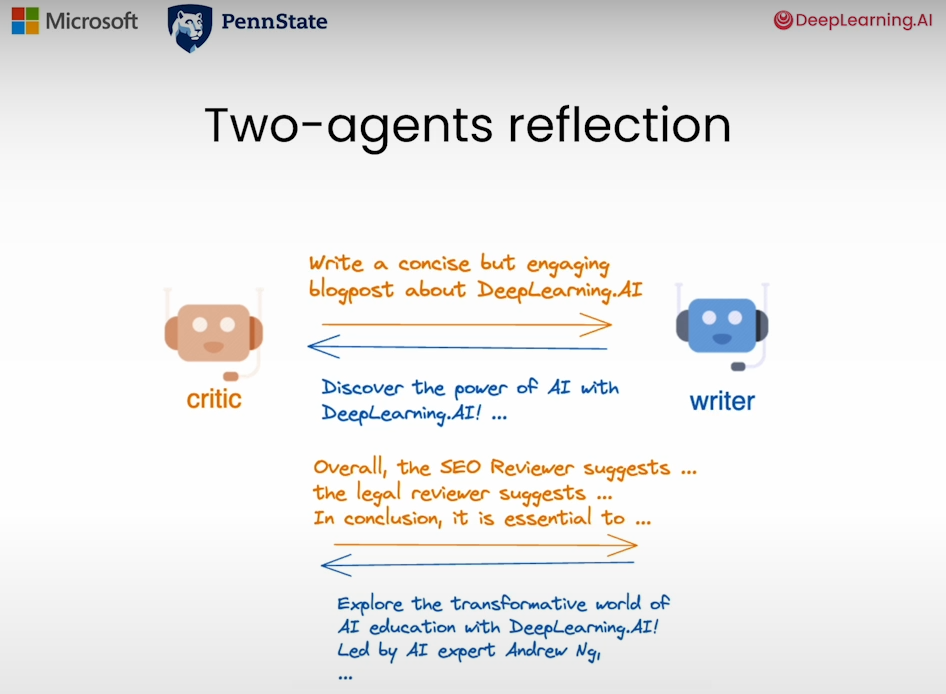

## Setup

In [1]:
llm_config = {"model": "gpt-3.5-turbo"}

## The task!

In [2]:
task = '''
        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       '''


## Create a writer agent

In [3]:
import autogen

writer = autogen.AssistantAgent(
    name="Writer",
    system_message="You are a writer. You write engaging and concise " 
        "blogpost (with title) on given topics. You must polish your "
        "writing based on the feedback you receive and give a refined "
        "version. Only return your final work without additional comments.",
    llm_config=llm_config,
)

In [4]:
reply = writer.generate_reply(messages=[{"content": task, "role": "user"}])

In [5]:
print(reply)

Title: Unveiling the World of DeepLearning.AI

Step into the extraordinary realm of DeepLearning.AI, where innovation and technology converge to shape the future. Offering cutting-edge courses and resources, DeepLearning.AI provides a gateway to unravel the mysteries of artificial intelligence and machine learning. With industry experts leading the way, learners are empowered to master complex concepts with ease. Whether you're a novice looking to explore this fascinating field or a seasoned professional aiming to advance your skills, DeepLearning.AI offers a pathway to excellence. Join this dynamic community today and embark on a transformative journey towards unlocking the full potential of AI.


## Adding reflection 

Create a critic agent to reflect on the work of the writer agent.

In [6]:
critic = autogen.AssistantAgent(
    name="Critic",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    llm_config=llm_config,
    system_message="You are a critic. You review the work of "
                "the writer and provide constructive "
                "feedback to help improve the quality of the content.",
)

In [7]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: Unveiling the World of DeepLearning.AI

Step into the extraordinary realm of DeepLearning.AI, where innovation and technology converge to shape the future. Offering cutting-edge courses and resources, DeepLearning.AI provides a gateway to unravel the mysteries of artificial intelligence and machine learning. With industry experts leading the way, learners are empowered to master complex concepts with ease. Whether you're a novice looking to explore this fascinating field or a seasoned professional aiming to advance your skills, DeepLearning.AI offers a pathway to excellence. Join this dynamic community today and embark on a transformative journey towards unlocking the full potential of AI.

---------------------------------

## Nested chat

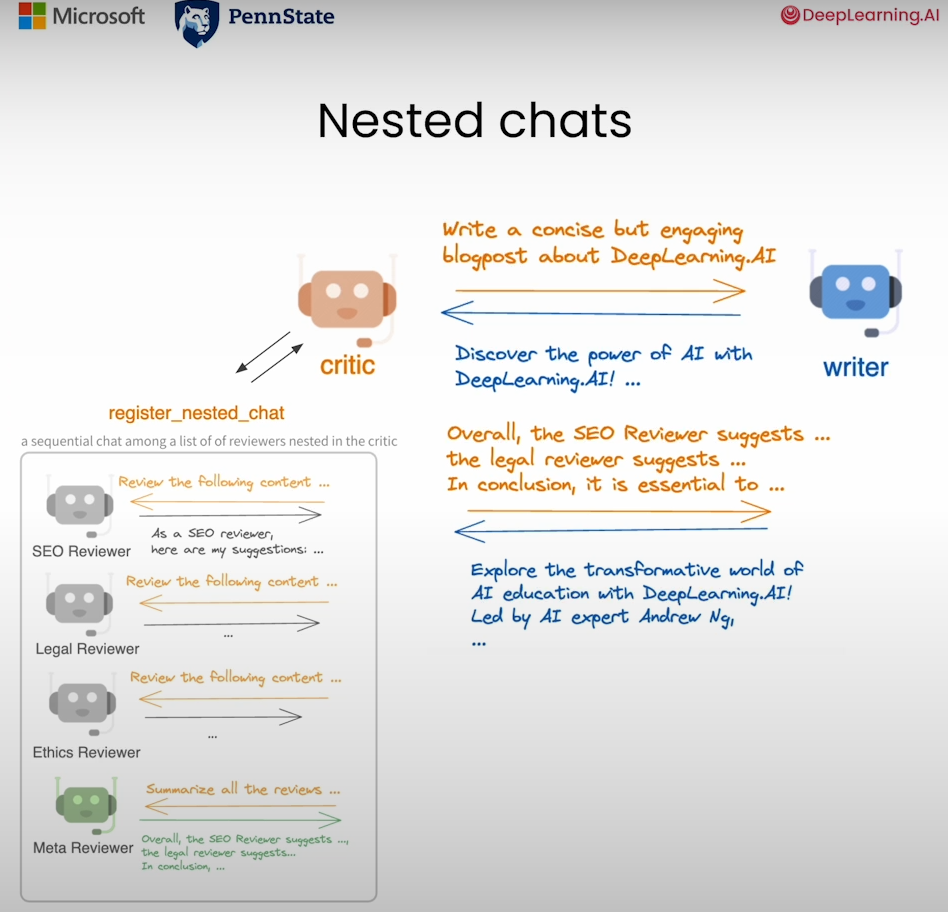
- In many cases, when they want to realize an even more complex reflection workflow as in the monologue of the critic agent. 
- For eg: when they want to ensure the critic agent to provide criticism regarding certain aspects of the work. For eg: whether content will rank well in search engines, whether it will attrcat organic traffics, whether it has legal problems and ethical problems etc.. 
- Nested chat can handle all this 
- ***Nested chat*** is effectively a chat registered as the inner monologue of ana agent

In [ ]:
# Lets create a bunch of reviewers within the critic agent to carefully examine different aspects of the writing
SEO_reviewer = autogen.AssistantAgent(
    name="SEO Reviewer",
    llm_config=llm_config,
    system_message="You are an SEO reviewer, known for "
        "your ability to optimize content for search engines, "
        "ensuring that it ranks well and attracts organic traffic. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)


In [9]:
legal_reviewer = autogen.AssistantAgent(
    name="Legal Reviewer",
    llm_config=llm_config,
    system_message="You are a legal reviewer, known for "
        "your ability to ensure that content is legally compliant "
        "and free from any potential legal issues. "
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role.",
)

In [10]:
ethics_reviewer = autogen.AssistantAgent(
    name="Ethics Reviewer",
    llm_config=llm_config,
    system_message="You are an ethics reviewer, known for "
        "your ability to ensure that content is ethically sound "
        "and free from any potential ethical issues. " 
        "Make sure your suggestion is concise (within 3 bullet points), "
        "concrete and to the point. "
        "Begin the review by stating your role. ",
)

In [11]:
meta_reviewer = autogen.AssistantAgent(
    name="Meta Reviewer",
    llm_config=llm_config,
    system_message="You are a meta reviewer, you aggragate and review "
    "the work of other reviewers and give a final suggestion on the content.",
)

## Orchestrate the nested chats to solve the task

In [12]:
def reflection_message(recipient, messages, sender, config):
   ''' This function responsibility is to gather the summary from the agents in the auto chat sessions
     and we are calling the chat_messages_for_summary as the initial message'''
   
   return f'''Review the following content. 
            \n\n {recipient.chat_messages_for_summary(sender)[-1]['content']}'''

review_chats = [
    {
     "recipient": SEO_reviewer, 
     "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}. Here Reviewer should be your role",},
     "max_turns": 1},
    {
    "recipient": legal_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'Reviewer': '', 'Review': ''}.",},
     "max_turns": 1},
    {"recipient": ethics_reviewer, "message": reflection_message, 
     "summary_method": "reflection_with_llm",
     "summary_args": {"summary_prompt" : 
        "Return review into as JSON object only:"
        "{'reviewer': '', 'review': ''}",},
     "max_turns": 1},
     {"recipient": meta_reviewer, 
      "message": "Aggregrate feedback from all reviewers and give final suggestions on the writing.", 
     "max_turns": 1},
]


In [13]:
critic.register_nested_chats(
    review_chats,
    trigger=writer, 
    # whenever the critic agent receives a message from this writer agent , it will automatically roll to the message to this nested chat session for carful refelction
)

**Note**: You might get a slightly different response than what's shown in the video. Feel free to try different task.

In [14]:
res = critic.initiate_chat(
    recipient=writer,
    message=task,
    max_turns=2,
    summary_method="last_msg"
)

Critic (to Writer):


        Write a concise but engaging blogpost about
       DeepLearning.AI. Make sure the blogpost is
       within 100 words.
       

--------------------------------------------------------------------------------
Writer (to Critic):

Title: Unveiling the World of DeepLearning.AI

Step into the extraordinary realm of DeepLearning.AI, where innovation and technology converge to shape the future. Offering cutting-edge courses and resources, DeepLearning.AI provides a gateway to unravel the mysteries of artificial intelligence and machine learning. With industry experts leading the way, learners are empowered to master complex concepts with ease. Whether you're a novice looking to explore this fascinating field or a seasoned professional aiming to advance your skills, DeepLearning.AI offers a pathway to excellence. Join this dynamic community today and embark on a transformative journey towards unlocking the full potential of AI.

---------------------------------


--------------------------------------------------------------------------------
Meta Reviewer (to Critic):

Aggregated Feedback:
1. SEO Specialist:
- Optimize keywords related to deep learning, AI, and machine learning for better search visibility.
- Enhance meta tags with relevant terms to increase click-through rate.
- Develop a backlink strategy to boost domain authority and credibility.

2. Legal Reviewer:
- Ensure the use of trademarks like "DeepLearning.AI" doesn't violate intellectual property rights.
- Conduct a trademark search to verify ownership and proper use.
- Confirm claims about courses and resources are substantiated and not misleading.
- Review privacy policy and terms of use for legal compliance concerning user data protection and terms of service.

3. Ethics Reviewer:
- Ensure claims about courses and resources are accurate and substantiated, avoiding misleading information.
- Review privacy policy and terms of use to safeguard user data protection and ensure lega

## Get the summary

In [15]:
print(res.summary)

Title: Navigating DeepLearning.AI: Empowering Your AI Journey

Embark on a transformative AI journey with DeepLearning.AI, your gateway to advanced machine learning and artificial intelligence. Dive into cutting-edge courses led by industry experts, empowering learners at every level. Unravel the complexities of AI confidently, whether you're a newcomer or seasoned professional. Enhance your skills and unlock AI's full potential within a vibrant community of innovators. Prioritizing legal compliance and transparency, DeepLearning.AI safeguards user data and upholds ethical standards. Elevate your knowledge with curated resources and embark on a trustworthy learning experience today. Welcome to a world of endless possibilities with DeepLearning.AI.
